參考 link :https://www.kaggle.com/code/ryotayoshinobu/foursquare-lightgbm-baseline
This notebook shows how to solve the problem as a multi-class classification by finding candidate points based on geographic location.<br>
Similarity as a string, such as edit distance and LCS (Longest Common Subsequence), was used for the features of the candidate points.<br>
<br>
Inference is made on test data only, but the code for training is left commented out.<br>
<br>
In addition, making the matches bidirectional as a post-processing step improved the score by about 1%.<br>
<br>

In [ ]:
! pip uninstall lightgbm -y

In [ ]:

! pip install lightgbm==3.3.1
! pip install sentence_transformers

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c foursquare-location-matching
! unzip foursquare-location-matching.zip

In [43]:
# from google.colab import drive
# drive.mount('/content/drive')

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import seaborn as sns
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib

# 宣告一個專門放參數的 class
class CFG: # configuration
    seed = 46
    target = "point_of_interest"
    n_neighbors = 10
    n_splits = 3

    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0]

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

# %cd /content/drive/MyDrive/kaggle/foursquare-location-matching/{CFG.expID}

In [45]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
test[CFG.target] = "TEST"
train = train[:5000]
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb


# Devide Train Data into about 600K×2

In [46]:
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train, train[CFG.target], train[CFG.target])):
    train.loc[val_idx, "set"] = i
train["set"].value_counts()

1.0    2500
0.0    2500
Name: set, dtype: int64

In [47]:
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,set
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1.0
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1.0
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,1.0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0.0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,0.0


# 資料代入 / 插補 / 填補 Data Imputation

In [48]:
from sklearn.neighbors import KNeighborsRegressor
# 把每一個地點都加上 另外一個最近地點的資訊
def add_neighbor_features(df):
    dfs = []
    # 需要 id 不然不沒辦法做後方 matches 的 set、沒辦法算分數
    columns = ['id', 'name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']
    # embedding_columns = ['name', 'categories']
    tfidf_columns = ['name', 'categories']

    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()
            
    # 把相同國家的 row 放進同一個 dataframe 裡面
    for country, country_df in tqdm(df.groupby("country")):
        country_df = country_df.reset_index(drop=True)
        # n_neighbors 表示要參考附近的幾筆資料才決定屬於哪一群
        k = min(len(country_df), CFG.n_neighbors)
        knn = KNeighborsRegressor(n_neighbors=k, 
                                  metric='haversine', n_jobs=-1)
        
        # 使用相同的"國家群"進行訓練
        # 同個國家的資料當成一群進行訓練
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        
        # 得出分群後的資料，回傳每個點與最近的幾個點的距離與 indices
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
        # 將 n_neighbors 各點的資料呈現在 country_df 上
        targets = country_df[CFG.target].values
        for i in range(k):
            country_df[f"d_near_{i}"] = dists[:, i]
            country_df[f"near_target_{i}"] = targets[nears[:, i]]
            for c in columns:
                country_df[f"near_{c}_{i}"] = country_df[c].values[nears[:, i]]
            # for c in embedding_columns:
                # country_df[f'near_embedding_{c}_{i}'] = make_embedding(country_df[c].values[nears[:, i]])
        # 若整個國家的資料點數量小於預設所需的 k ，則將多出的部分填補為 nan
        for i in range(k, CFG.n_neighbors):
            country_df[f"d_near_{i}"] = np.nan
            country_df[f"near_target_{i}"] = np.nan
            for c in columns:
                country_df[f"near_{c}_{i}"] = np.nan
            # for c in embedding_columns:
            #     country_df[f'near_embedding_{c}_{i}'] = np.nan

        dfs.append(country_df)
        # # for look inside
        # df = pd.concat(dfs).reset_index(drop=True) # for look inside
        # df.head()
        # break
    df = pd.concat(dfs).reset_index(drop=True)
    # 加上 tfidf 數據
    # for c in tfidf_columns:
    #     total_columns = []
    #     for i in range(CFG.n_neighbors):
    #         total_columns += list(df[f"near_{c}_{i}"].fillna('no'))
    #     if c == 'name':
    #         total_name_result =  make_tfidf(total_columns)
    #         print(len(total_name_result))
    #     elif c == 'categories':
    #         total_cate_result = make_tfidf(total_columns)
    #         print(len(total_cate_result))
    # for c in tfidf_columns:
    #     for i in range(CFG.n_neighbors):
    #         if c == 'name':
    #             df[f'near_tfidf_{c}_{i}'] = total_name_result[len(df)*i:len(df)*(i+1)]
    #         elif c == 'categories':
    #             df[f'near_tfidf_{c}_{i}'] = total_cate_result[len(df)*i:len(df)*(i+1)]

    return df


In [49]:
# original_train = train

In [50]:
# add_neighbor_features(original_train)

In [51]:
# train

In [52]:
# 擴充 train 的 n_neighbors 的資料
train = pd.concat([
    add_neighbor_features(train[train["set"]==0]), 
    add_neighbor_features(train[train["set"]==1]), 
])
# train = add_neighbor_features(train)
test = add_neighbor_features(test)

train.head(1)

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_id_9,near_name_9,near_address_9,near_city_9,near_state_9,near_zip_9,near_country_9,near_url_9,near_phone_9,near_categories_9
0,E_0019ce8998b3a8,cinnabon سينابون,25.133606,55.18603,souk madinat,dubai,nan,nan,ae,nan,...,E_0031c764c706c6,bowling marina mall,nan,nan,nan,nan,ae,nan,nan,bowling alleys


In [53]:
train

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_id_9,near_name_9,near_address_9,near_city_9,near_state_9,near_zip_9,near_country_9,near_url_9,near_phone_9,near_categories_9
0,E_0019ce8998b3a8,cinnabon سينابون,25.133606,55.186030,souk madinat,dubai,nan,nan,ae,nan,...,E_0031c764c706c6,bowling marina mall,nan,nan,nan,nan,ae,nan,nan,bowling alleys
1,E_002e4c4793fbc7,s.p. warehousing,24.976119,55.189455,"plot no. 597-900, dubai investments park second",dubai,nan,nan,ae,nan,...,E_0031c764c706c6,bowling marina mall,nan,nan,nan,nan,ae,nan,nan,bowling alleys
2,E_0030de94b528e7,al derwaza,24.331331,54.524466,dalma mall,abu dhabi,abu dhabi,nan,ae,nan,...,E_0117b75aff7fcb,كَفْتِيرْيَا الرَّبِيع الأَخْضَر (بَحَر الشَّا...,الإِمَارَات الْعَرَبِيَة الْمُتَّحِدَة,الشَّارْجَة,nan,nan,ae,nan,nan,cafeterias
3,E_0031c764c706c6,bowling marina mall,24.473879,54.350251,nan,nan,nan,nan,ae,nan,...,E_0117b75aff7fcb,كَفْتِيرْيَا الرَّبِيع الأَخْضَر (بَحَر الشَّا...,الإِمَارَات الْعَرَبِيَة الْمُتَّحِدَة,الشَّارْجَة,nan,nan,ae,nan,nan,cafeterias
4,E_006d916aa271d3,بالشارع,25.364507,55.160438,sharjah,sharjah,nan,nan,ae,nan,...,E_0030de94b528e7,al derwaza,dalma mall,abu dhabi,abu dhabi,nan,ae,nan,nan,middle eastern restaurants
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,E_00ee765fb1b37f,sea point,-33.917313,18.388428,nan,cape town,wc,8005,za,nan,...,E_000695824236ae,standard bank,"shop 338, maponya mall",soweto,gauteng,1809,za,http://www.standardbank.co.za,119833701,banks
2496,E_00f724c237a032,randridge mall,-26.101186,27.941699,randpark ridge,randburg,gauteng,2156,za,http://www.randridgemall.co.za,...,E_00d91a55160e8c,virgin active,hilda st. hatfield,pretoria,gauteng,0083,za,http://www.virginactive.co.za,123428739,"gyms or fitness centers, gyms"
2497,E_00f7eda6d0bdc1,nando's,-26.086427,27.781134,nan,nan,nan,nan,za,nan,...,E_00d91a55160e8c,virgin active,hilda st. hatfield,pretoria,gauteng,0083,za,http://www.virginactive.co.za,123428739,"gyms or fitness centers, gyms"
2498,E_00fc63af185765,moyo,-33.792636,18.457537,eden on the bay,bloubergstrand,wc,7441,za,http://www.moyo.co.za,...,E_000695824236ae,standard bank,"shop 338, maponya mall",soweto,gauteng,1809,za,http://www.standardbank.co.za,119833701,banks


# Analysis: Threshold


## 順位法
以距離順位(k)為基準分析趨勢：
1. 判斷多近「還有機會」是同個 POI
    * 後面的結果會覆蓋前面的結果
2. (?) 判斷多近「就會」是同個 POI
    * p.s.「多近」是以距離順位（第幾近）來判斷，而非是以絕對距離來看。
3. 判斷第一個 match 在哪 (0)

In [54]:
train.loc[:,"target"] = 0
# 1.
# [x] 判斷前幾個相同分群的經緯度是相同 POI
## 有可能第 2 個不同但第 4 個同，而 4 覆蓋掉 2，因此不代表前四個都是相同
## [?] 但此處的問題為，把經緯度分群當成唯一影響，所以才直接照順序決定 target(同一個 POI 的情況下，最大的 i)

# for i in range(CFG.n_neighbors):
#     print(train[CFG.target]==train[f"near_target_{i}"])
#     train.loc[train[CFG.target]==train[f"near_target_{i}"], "target"] = i

# 2. (after 1.)
# # wtf is that? >by Howard
train.loc[:,"not done"] = True
for i in tqdm(range(CFG.n_neighbors)):
    train.loc[train[CFG.target]!=train[f"near_target_{i}"], "not done"] = False
    train.loc[(train[CFG.target]==train[f"near_target_{i}"]) & (train["not done"]), "target"] = i

# 3.
# for i in range(CFG.n_neighbors-1, -1, -1):
# #     print(train[CFG.target]==train[f"near_target_{i}"])
#     train.loc[train[CFG.target]==train[f"near_target_{i}"], "target"] = i
    
    
# list(train.columns)

  0%|          | 0/10 [00:00<?, ?it/s]

In [55]:
train['target'].max()

1

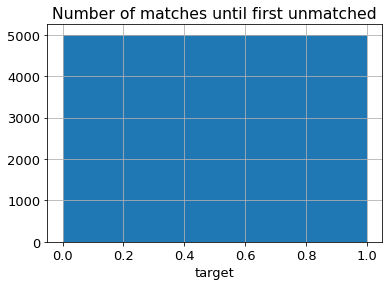

In [56]:
plt.hist(train["target"], bins=sorted(train["target"].unique()))
plt.grid()
plt.xlabel("target")
plt.title('Number of matches until first unmatched')
# plt.title('Number of the last match')
plt.show()

## 絕對距離法
直接以距離的值來判定

In [57]:
# for index, row in train.iterrows():
# #     print("row", row)
# #     print("row['target']", row["target"])
# #     print("row[row['target']]", row[row["target"]])
# #     if index == 3:
# #         break
#     ## wtf is that? >by Howard
#     row["max_dist"] = row[row["target"]]


# for i in range(CFG.n_neighbors):
#     train.loc[train[CFG.target]!=train[f"near_target_{i}"], "done"] = True
#     ## Assign i to all elements in train['target'] where train['POI']==train[near_target_i]
#     train.loc[(train[CFG.target]==train[f"near_target_{i}"]) & (train["done"] != True), "target"] = train[f"d_near_{i}"]
    
# list(train.columns)
# train['target'].head(10)

# Validation

## Two-way Hash
用雜湊表來將正確答案產出

In [58]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics

## 將input dataframe 轉成 dict，再拿出 id 與 poi 用 dict 回傳
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

## 將input dataframe 轉成 dict，再以 poi 為 index、取出"屬於此 poi"的 id set 用 dict 回傳
def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

id2poi = get_id2poi(train)
poi2ids = get_poi2ids(train)

## 比對
利用 KNN 的結果做出預測，再與正確答案做比對

In [59]:
## 已有 matches
def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        # 找出與該 id 相同 poi 之所有 id
        targets = poi2ids[id2poi[id_str]]
        # 整理 matches 格式 (根據 train + knn 所得) (以空格分割)
        preds = set(matches.split())
        # 比分數
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

In [60]:
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_address_9,near_city_9,near_state_9,near_zip_9,near_country_9,near_url_9,near_phone_9,near_categories_9,target,not done
0,E_0019ce8998b3a8,cinnabon سينابون,25.133606,55.186030,souk madinat,dubai,nan,nan,ae,nan,...,nan,nan,nan,nan,ae,nan,nan,bowling alleys,0,False
1,E_002e4c4793fbc7,s.p. warehousing,24.976119,55.189455,"plot no. 597-900, dubai investments park second",dubai,nan,nan,ae,nan,...,nan,nan,nan,nan,ae,nan,nan,bowling alleys,0,False
2,E_0030de94b528e7,al derwaza,24.331331,54.524466,dalma mall,abu dhabi,abu dhabi,nan,ae,nan,...,الإِمَارَات الْعَرَبِيَة الْمُتَّحِدَة,الشَّارْجَة,nan,nan,ae,nan,nan,cafeterias,0,False
3,E_0031c764c706c6,bowling marina mall,24.473879,54.350251,nan,nan,nan,nan,ae,nan,...,الإِمَارَات الْعَرَبِيَة الْمُتَّحِدَة,الشَّارْجَة,nan,nan,ae,nan,nan,cafeterias,0,False
4,E_006d916aa271d3,بالشارع,25.364507,55.160438,sharjah,sharjah,nan,nan,ae,nan,...,dalma mall,abu dhabi,abu dhabi,nan,ae,nan,nan,middle eastern restaurants,0,False


In [61]:
scores = []
# 用 poi 去 check 每一個 n_neighors 的 poi，把 poi 相同的 id 加在 matches 這個新增的 column
# 此外這裡每次多考慮一個 neighbor，就多算一次分數
train["matches"] = ""
for i in tqdm(range(CFG.n_neighbors)):
    # 一次是看某一個i，直的一整大排去賦值
    idx = train[CFG.target]==train[f"near_target_{i}"]
    # idx 裡面是 true 才會 access 到那一個 row
    train.loc[idx, "matches"] += " " + train.loc[idx, f"near_id_{i}"]
    # 算分數囉～
    scores.append(get_score(train))
# 把紀錄刪光光
train["matches"] = None

  0%|          | 0/10 [00:00<?, ?it/s]

[0.9974, 0.9996, 0.9998, 0.9999, 0.9999, 1.0, 1.0, 1.0, 1.0, 1.0]


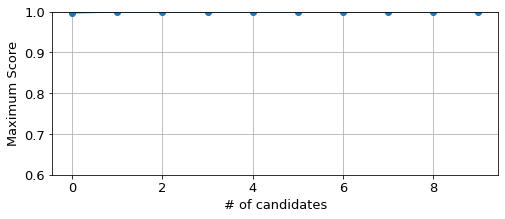

In [62]:
# 會發現每多考慮一個 candidate 分數就可以提高
plt.subplots(figsize=(8, 3), facecolor="white")
print(scores)
plt.plot(range(CFG.n_neighbors), scores, marker="o")
plt.grid()
plt.xlabel("# of candidates")
plt.ylabel("Maximum Score")
plt.ylim([0.6, 1.0])
plt.show()

In [63]:
# 清記憶體垃圾
# del train
gc.collect()

4801

In [64]:
train = train.drop('matches', axis=1)
train = train.drop('not done', axis=1)

In [65]:
train.iloc[0]

id                   E_0019ce8998b3a8
name                 cinnabon سينابون
latitude                    25.133606
longitude                    55.18603
address                  souk madinat
                           ...       
near_country_9                     ae
near_url_9                        nan
near_phone_9                      nan
near_categories_9      bowling alleys
target                              0
Name: 0, Length: 135, dtype: object

# Feature Engineering

## tfidf

In [66]:
def get_tfidf_score(df1, df2):
    temp_concate_list = list(df1.fillna("nope")) + list(df2.fillna("nope"))

    tv = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None)
    tv_fit = tv.fit_transform(temp_concate_list)

    temp_result = tv_fit.toarray().tolist()
    temp_list1 = temp_result[:len(df1)]
    temp_list2 = temp_result[len(df1):]

    score_2d_list = cosine_similarity(temp_list1, temp_list2)
    score_1d_list = [score_2d_list[i][i] for i in range(len(score_2d_list))]


    return score_1d_list

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

def make_tfidf(input_columns):
  tv = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None)
  tv_fit = tv.fit_transform(input_columns)
  tv_fit = tv_fit.toarray().tolist()
  # 把二維向量中的其中一維轉成 string 儲存
  str_tv_fit = [str(tv_fit[i]) for i in range(len(tv_fit))]
  

  return str_tv_fit

In [68]:
from sklearn.metrics.pairwise import cosine_similarity
import ast
# 這裡給兩個一維 dataframe, 可以跑出相同維度的分數
def cal_similarity(list_1, list_2):
    # 把一維string 轉成二維向量
    tf_1 = list(map(ast.literal_eval, list_1))
    tf_2 = list(map(ast.literal_eval, list_2))
    
    score_2d_list = cosine_similarity(tf_1, tf_1)

    score_1d_list = [score_2d_list[i][i] for i in range(len(score_2d_list))]
    return score_1d_list

## 其他比對 featrues

In [69]:
if "google.colab" in sys.modules:
    !pip install Levenshtein

y
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [70]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [71]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [94]:
# 利用 Levenshtein、difflib 算出兩字串的各種 features 相異程度數值，並把數值加入到 features 內
import Levenshtein
import difflib

def _add_distance_features(args):
    # _, df = args
    df = args
    columns = ['name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']

    for i in tqdm(range(CFG.n_neighbors)):
        for c in columns:
            geshs = []
            levens = []
            jaros = []
            lcss = []
            sentence_transformer = []
            str_enter_count = 0
            for str1, str2 in df[[f"near_{c}_0", f"near_{c}_{i}"]].values.astype(str):
                # 一次只會進來一次，所以 for 是為了取值用的～
                str_enter_count += str_enter_count
                if str_enter_count >= 2:
                    print("bigger than 2","i = ", i,"c =", c)
                # 檢查是否為 NaN
                if str1==str1 and str2==str2:
                    geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                    levens.append(Levenshtein.distance(str1, str2))
                    jaros.append(Levenshtein.jaro_winkler(str1, str2))
                    lcss.append(LCS(str(str1), str(str2)))
                else:
                    geshs.append(-1)
                    levens.append(-1)
                    jaros.append(-1)
            df[f"near_{c}_{i}_gesh"] = geshs
            df[f"near_{c}_{i}_leven"] = levens
            df[f"near_{c}_{i}_jaro"] = jaros
            df[f"near_{c}_{i}_lcs"] = lcss

            # 如果是 namen, address, city, state, url, categories 的情況下，再多加一個平均的 feature
            if not c in ['country', "phone", "zip"]:
                df[f"near_{c}_{i}_len"] = df[f"near_{c}_{i}"].astype(str).map(len)
                df[f"near_{c}_{i}_nleven"] = df[f"near_{c}_{i}_leven"] / df[[f"near_{c}_{i}_len", f"near_{c}_0_len"]].max(axis=1)
                df[f"near_{c}_{i}_nlcsi"] = df[f"near_{c}_{i}_lcs"] / df[f"near_{c}_{i}_len"]
                df[f"near_{c}_{i}_nlcs0"] = df[f"near_{c}_{i}_lcs"] / df[f"near_{c}_0_len"]
            ########################################################################################
            # 加上 tfidf 兩兩比較的分數
            if c in ['name', 'categories']:
                df[f"near_{c}_{i}_tfidf_score"] = get_tfidf_score(df[f"near_{c}_0"], df[f"near_{c}_{i}"])
                empty_selector = df[f"near_{c}_{i}"] != df[f"near_{c}_{i}"]
                df.loc[empty_selector , f"near_{c}_{i}_tfidf_score"] = -1
            ########################################################################################
    return df

# muilty processing
def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

In [95]:
len(train)

5000

In [96]:
train = train.sample(frac=0.8, random_state=25)

##stop plz

In [98]:
train = _add_distance_features(train)
# test = add_distance_features(test)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# plt.subplots(figsize=(8, 3), facecolor="white")

# plt.plot(range(len(train_result)), train_result, marker="o")
# plt.grid()
# plt.xlabel("data id")
# plt.ylabel("similarity")
# plt.ylim([-1, 1.0])
# plt.title('data = 5000, near_name_9')
# plt.show()

In [ ]:
# train_result.unique()

# Delete Unusing Columns for avoiding OOM (out of memory)

In [ ]:
# 在上面的 block 我們已經把新的 feature 加入到 dataframe 內了，這裡 features 的目的就是為了移掉其他不重要的 features
features = []

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']
for i in tqdm(range(CFG.n_neighbors)):
    features.append(f"d_near_{i}")
    for c in columns:        
        features += [f"near_{c}_{i}_gesh", f"near_{c}_{i}_jaro", f"near_{c}_{i}_lcs"]
        if c in ['country', "phone", "zip"]:
            features += [f"near_{c}_{i}_leven"]
        else:
            features += [f"near_{c}_{i}_len", f"near_{c}_{i}_nleven", f"near_{c}_{i}_nlcsi", f"near_{c}_{i}_nlcs0"]
        ########################################################################################
        # 加上 tfidf
        if c in ['name', 'categories']:
            features += [f"near_{c}_{i}_tfidf_score"]
        ########################################################################################

for f in features:
#     assert f in train.columns
    if f not in train.columns:
        train[f] = np.nan
    # if f not in test.columns:
    #     test[f] = np.nan

# print(features)

In [ ]:
# 把剛剛所有資訊放進 train 與 test
train = train[features + [CFG.target, "target", "id"] + [f"near_id_{i}" for i in range(CFG.n_neighbors)]]
# test = test[features + ["id"] + [f"near_id_{i}" for i in range(CFG.n_neighbors)]]

train[features] = train[features].astype(np.float16)
# test[features] = test[features].astype(np.float16)

train["target"] = train["target"].fillna(0)

train.reset_index(drop=True, inplace=True)
# test.reset_index(drop=True, inplace=True)

for _ in range(5):
    gc.collect()

# train.info()

**訓練與測試資料的格式???**
- X 包含 
    - CFT 的資訊
    - n_neighber = 10, 的所有資訊
    - n_neighber 跟 CFT.target 相關的所有字串配對分數
- y 包含
    - 相同 POI 之中，最大的 neighber

# Split Folds

In [ ]:
# kf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
# shuffle 應該要是 false? 這樣每個點都才會被平均的當成訓練資料，不會漏掉 > Howard
kf = StratifiedKFold(n_splits=CFG.n_splits) 
for i, (trn_idx, val_idx) in tqdm(enumerate(kf.split(train, train["target"], train["target"]))):
    print(i, len(trn_idx), len(val_idx))
    train.loc[val_idx, "fold"] = i

# Model Learning
使用 lightGBM 演算法

In [ ]:
import lightgbm as lgbm

# n-class 表示分類結果有哪些, n_split 表示 k-fold 做幾次
def fit_lgbm(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), n_class), dtype=np.float64)
    
    # 不同的 split number 就存不同的模型 k-fold cross validation> Howard
    for i in tqdm(range(CFG.n_splits)):
        print(f"== fold {i} ==")
        # 把剛剛分完群的拿出來
        trn_idx = folds!=i
        val_idx = folds==i
        # 拿出不同 dataframe
        X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
        # 不存在就訓練
        if model_dir is None:
            model = lgbm.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
              eval_metric='logloss',  
        #       verbose=-1)
                verbose=50)
        # 存在就 load 出來, 等等跑分數
        else:
            with open(f'{model_dir}/lgbm_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
        # X_valid 如果是100 筆數據, 且 5個 class,那 pred 的 dimension = (100, 5)
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = f'lgbm_fold{i}.pkl'
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models
# 直接用 model.predict_proba 跑結果
def inference_lgbm(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

## 開始訓練資料

In [ ]:
train["target"].max()

In [ ]:
# train.to_csv('train_need_check_tfidf.csv', index=False)

In [ ]:
len(train)

In [ ]:
# train = pd.read_csv('train_need_check_tfidf.csv')

In [ ]:
train

In [ ]:
params = {
    'objective': "logloss",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}

oof, models = fit_lgbm(train[features], train["target"].astype(int), 
                       params=params, n_class=int(train["target"].max()+ 1),
                       N_SPLITS=CFG.n_splits, folds=train["fold"].values)


In [ ]:
# 根據不同的分組，拿出不同的 model
models = [joblib.load(f'lgbm_fold{i}.pkl') for i in range(CFG.n_splits)]
# 這裡直接測試test data 並回傳 k-fold 不同模型的預測結果平均
pred = inference_lgbm(models, test[features])

# Check CV

In [ ]:
# 每個 id 的周遭 10 個 ids 為誰 (dimension = i * 10)
near_ids = train[[f"near_id_{i}" for i in range(CFG.n_neighbors)]].values

matches = []
# 掃過全部的 train row ，得出其中的 id
# ps 為所有 id 的預測結果
# ids 周遭 10 個 id 為誰
for id, ps, ids in tqdm(zip(train["id"], oof, near_ids)):
    # 找出最大的那個 class 的值，代表預測的 target 是多少
    idx = np.argmax(ps)
    matches_string = id

    # 如果 idx > 0, 就把小於的也加上去
    if idx > 0:
      for idx_count in range(1, idx+1):
        if ids[idx_count] == ids[idx_count]:
            matches_string += " "
            matches_string += ids[idx_count] 
    matches.append(matches_string)
train["matches"] = matches
print(f"CV: {get_score(train):.6f}")

In [ ]:
# # 每個 id 的周遭 10 個 ids 為誰 (dimension = i * 10)
# near_ids = train[[f"near_id_{i}" for i in range(CFG.n_neighbors)]].values

# matches = []
# # 掃過全部的 train row ，得出其中的 id
# # ps 為所有 id 的預測結果
# # ids 周遭 10 個 id 為誰
# for id, ps, ids in tqdm(zip(train["id"], oof, near_ids)):
#     # 找出最大的那個 class 的值，代表預測的 target 是多少
#     idx = np.argmax(ps)
#     # 如果 idx 不是自己，且也不是 Nan, 就 append 自己 跟 idx 進去
#     if idx > 0 and ids[idx]==ids[idx]:
#         matches.append(id + " " + ids[idx])
#     # 否則只 append 自己
#     else:
#         matches.append(id)
# train["matches"] = matches
# print(f"CV: {get_score(train):.6f}")

In [ ]:
# # test one more time
# near_ids = test[[f"near_id_{i}" for i in range(CFG.n_neighbors)]].values

# matches = []
# for id, ps, ids in tqdm(zip(test["id"], pred, near_ids)):
#     idx = np.argmax(ps)
#     if idx > 0 and ids[idx]==ids[idx]:
#         matches.append(id + " " + ids[idx])
#     else:
#         matches.append(id)
# test["matches"] = matches

# Check Feature Importances

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

# Simple Post-Processing

In [ ]:
def postprocess(df):
    id2match = dict(zip(df["id"].values, df["matches"].str.split()))

    for match in tqdm(df["matches"]):
        match = match.split()
        if len(match) == 1:        
            continue
        
        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    df["matches"] = df["id"].map(id2match).map(" ".join)
    return df 

#train = postprocess(train)
test = postprocess(test)
# print(f"CV: {get_score(train):.6f}")

In [ ]:
test

# Submit

In [ ]:
ssub = pd.read_csv("submission.csv")
ssub = ssub.drop(columns="matches")
ssub = ssub.merge(test[["id", "matches"]], on="id")
ssub.to_csv("submission.csv", index=False)

ssub.head()